
# pPXF: Montecarlo simulation to estimate `bias` parameter

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example it is useful to determine the desired value for
the `bias` keyword of the `pPXF` procedure. This procedure generates
a plot similar (but not identical) to Figure 6 in
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C).

A rough guideline to determine the BIAS value is the following: choose the
*largest* value which make sure that in the range `sigma > 3*velScale` and
for $(S/N)>30$ the true values for the Gauss-Hermite parameters are well
within the rms scatter of the measured values. See the documentation in the
file `ppxf.py` for a more accurate description.

### MODIFICATION HISTORY

- V1.0.0: By Michele Cappellari, Leiden, 28 March 2003
- V1.1.0: Included in the standard PPXF distribution. After feedback
      from Alejandro Garcia Bedregal. MC, Leiden, 13 April 2005
- V1.1.1: Adjust GOODPIXELS according to the size of the convolution kernel.
      MC, Oxford, 13 April 2010
- V1.1.2: Use Coyote Graphics (http://www.idlcoyote.com/) by David W. Fanning.
      The required routines are now included in NASA IDL Astronomy Library.
      MC, Oxford, 29 July 2011
- V2.0.0: Translated from IDL into Python. MC, Oxford, 9 December 2013
- V2.0.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
- V2.0.2: Support both Pyfits and Astropy to read FITS files.
      MC, Oxford, 22 October 2015
- V2.0.3: Use random input velocity to properly simulate situations with
      undersampled LOSVD. MC, Oxford, 20 April 2016
- V2.1.0: Replaced the Vazdekis-99 SSP models with the Vazdekis+10 ones.
      Modified plot to emphasize undersampling effect. MC, Oxford, 3 May 2016
- V2.1.1: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
- V2.1.2: Updated MILES file name. MC, Oxford, 29 November 2017
- V2.1.3: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V2.1.4: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V4.0.3: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V4.1.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V4.2.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
- V4.2.1: Use updated random generator default_rng. 
      MC, Oxford, 16 March 2024
___

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request

from scipy import ndimage, signal
import numpy as np
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

Read SPS models file from my GitHub if not already in the `pPXF` package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).
Here below I select a single SPS template as mock spectrum.

In [2]:
ppxf_dir = Path(util.__file__).parent

rng = np.random.default_rng(123)  # For reproducible results
 
lam_range_temp = [3500, 7500]
sps_name = 'emiles'
velscale = 35   # km/s

basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

sps = lib.sps_lib(filename, velscale, wave_range=lam_range_temp)

spectrum = sps.templates[:, -2, -2]  # age = 12.59 Gyr [M/H] = 0
lamRange = [np.min(sps.lam_temp), np.max(sps.lam_temp)]

star, logLam, velscale = util.log_rebin(lamRange, spectrum, velscale=velscale)

The finite sampling of the observed spectrum is modelled in detail:
the galaxy spectrum is obtained by oversampling the actual observed spectrum
to a high resolution. This represents the true spectrum, which is later resampled
to lower resolution to simulate the observations on the CCD. Similarly, the
convolution with a well-sampled LOSVD is done on the high-resolution spectrum,
and later resampled to the observed resolution before fitting with PPXF.

In [3]:
factor = 10                    # Oversampling integer factor for an accurate convolution
starNew = ndimage.zoom(star, factor, order=3) # This is the underlying spectrum, known at high resolution
star = rebin(starNew, factor)        # Make sure that the observed spectrum is the integral over the pixels

h3 = 0.1       # Adopted G-H parameters of the LOSVD
h4 = 0.1
sn = 30.        # Adopted S/N of the Monte Carlo simulation
m = 300        # Number of realizations of the simulation
moments = 4
velV = rng.uniform(size=m)      # velocity in *pixels* [=V(km/s)/velScale]
sigmaV = np.linspace(0.5, 4, m) # Range of sigma in *pixels* [=sigma(km/s)/velScale]

result = np.zeros((m, moments)) # This will store the results
t = clock()

for j, (vel, sigma) in enumerate(zip(velV, sigmaV)):

    quiet = False if j < 3 else True  # Only print results for the first few fits

    dx = int(abs(vel) + 5*sigma)   # Sample the Gaussian and GH at least to vel+5*sigma
    x = np.linspace(-dx, dx, 2*dx*factor + 1) # Evaluate the Gaussian using steps of 1/factor pixels.
    w = (x - vel)/sigma
    w2 = w**2
    gauss = np.exp(-0.5*w2)
    gauss /= np.sum(gauss)  # Normalized total(gauss)=1
    h3poly = w*(2.*w2 - 3.)/np.sqrt(3.)             # H3(y)
    h4poly = (w2*(4.*w2 - 12.) + 3.)/np.sqrt(24.)   # H4(y)
    losvd = gauss *(1. + h3*h3poly + h4*h4poly)

    galaxy = signal.fftconvolve(starNew, losvd, mode="same") # Convolve the oversampled spectrum
    galaxy = rebin(galaxy, factor) # Integrate spectrum into original spectral pixels
    noise = galaxy/sn        # 1sigma error spectrum
    galaxy = rng.normal(galaxy, noise) # Add noise to the galaxy spectrum
    start = np.array([vel + rng.uniform(-1, 1), sigma*rng.uniform(0.8, 1.2)])*velscale  # Convert to km/s

    pp = ppxf(star, galaxy, noise, velscale, start,
                goodpixels=np.arange(dx, galaxy.size - dx),
                plot=False, moments=moments, bias=0.1, quiet=quiet)
    result[j,:] = pp.sol

print('Calculation time: %.2f s' % (clock()-t))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        24        21     0.049     0.001
chi2/DOF: 1.005; DOF: 6518; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
      1.06
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:         4        19     0.012     0.104
chi2/DOF: 0.9964; DOF: 6520; degree = 4; mdegree = 0
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
     0.996
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        11        23    -0.011    -0.034
chi2/DOF: 0.9975; DOF: 6520; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 27; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/1
Templates weights:
      1.08
Calculation time: 10.11 s


# Plot results

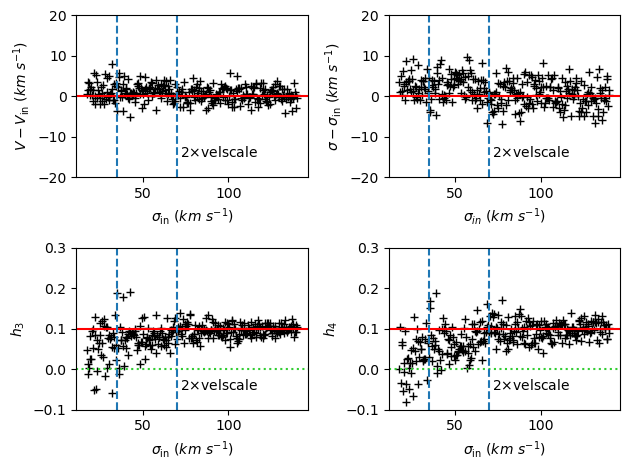

In [4]:
plt.clf()
plt.subplot(221)
plt.plot(sigmaV*velscale, result[:,0] - velV*velscale, '+k')
plt.axhline(0, color='r')
plt.axvline(velscale, linestyle='dashed')
plt.axvline(2*velscale, linestyle='dashed')
plt.ylim(-20, 20)
plt.xlabel(r'$\sigma_{\rm in}\ (km\ s^{-1})$')
plt.ylabel(r'$V - V_{\rm in}\ (km\ s^{-1})$')
plt.text(2.05*velscale, -15, r'2$\times$velscale')

plt.subplot(222)
plt.plot(sigmaV*velscale, result[:,1] - sigmaV*velscale, '+k')
plt.axhline(0, color='r')
plt.axvline(velscale, linestyle='dashed')
plt.axvline(2*velscale, linestyle='dashed')
plt.ylim(-20, 20)
plt.xlabel(r'$\sigma_{in}\ (km\ s^{-1})$')
plt.ylabel(r'$\sigma - \sigma_{\rm in}\ (km\ s^{-1})$')
plt.text(2.05*velscale, -15, r'2$\times$velscale')

plt.subplot(223)
plt.plot(sigmaV*velscale, result[:,2], '+k')
plt.axhline(h3, color='r')
plt.axhline(0, linestyle='dotted', color='limegreen')
plt.axvline(velscale, linestyle='dashed')
plt.axvline(2*velscale, linestyle='dashed')
plt.ylim(-0.2+h3, 0.2+h3)
plt.xlabel(r'$\sigma_{\rm in}\ (km\ s^{-1})$')
plt.ylabel('$h_3$')
plt.text(2.05*velscale, h3 - 0.15, r'2$\times$velscale')

plt.subplot(224)
plt.plot(sigmaV*velscale, result[:,3], '+k')
plt.axhline(h4, color='r')
plt.axhline(0, linestyle='dotted', color='limegreen')
plt.axvline(velscale, linestyle='dashed')
plt.axvline(2*velscale, linestyle='dashed')
plt.ylim(-0.2+h4, 0.2+h4)
plt.xlabel(r'$\sigma_{\rm in}\ (km\ s^{-1})$')
plt.ylabel('$h_4$')
plt.text(2.05*velscale, h4 - 0.15, r'2$\times$velscale')

plt.tight_layout()
plt.pause(5);